<span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Dataset Download and Upload in the Colab </h1></span>

For downloading and importing the dataset in you colab please follow the following steps:

*   Go to https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp
*   Download the dataset. It will be downloaded as **archive.zip** in your pc
*   Upload the dataset by running the following code cells




In [ ]:
from google.colab import files

# Prompt user to upload a folder
uploaded = files.upload()

Saving archive.zip to archive.zip


In [ ]:
!unzip /content/archive.zip -d .

Archive:  /content/archive.zip
  inflating: ./test.txt              
  inflating: ./train.txt             
  inflating: ./val.txt               


<span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Emotion Recognition using Finetuning BERT </h1></span>

Emotion recognition is a rapidly growing field that has numerous applications in various industries. One of the most popular approaches to emotion recognition is using natural language processing (NLP) techniques, such as sentiment analysis and affective computing. In this article, we'll explore the concept of emotion recognition using NLP and discuss its applications, benefits, and limitations.

<a href="https://arxiv.org/abs/1810.04805"> BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding</a> is a powerful language model that can be fine-tuned for various natural language processing (NLP) tasks, including sentiment analysis. Compared to traditional machine learning models, BERT has several advantages that make it well-suited for analyzing text data. First, BERT uses a multi-layer bidirectional transformer encoder to generate contextualized representations of words in a sentence, allowing it to capture both local and global dependencies between words. Second, BERT is trained on a large corpus of text data, which means it has learned to represent words in a way that is useful for a wide range of NLP tasks. Third, because BERT is a pre-trained model, it can be easily adapted to new tasks like sentiment analysis by adding a simple output layer on top of the existing model architecture. Overall, using BERT for sentiment analysis can lead to better performance and faster convergence compared to traditional machine learning models.

In [ ]:
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import string
import pickle
import random
import joblib
import itertools
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold


import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

tokenizers.__version__: 0.20.3
transformers.__version__: 4.46.3
env: TOKENIZERS_PARALLELISM=true
cuda


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Configuration File </h1></span>

It is very similar to yaml file. We are using a config class instead of yaml file. In the config file, we are setting all the hyperparameters and essential variable assignment

In [ ]:
class CFG:
    debug=True # want to debug or not
    apex=True # for faster training
    print_freq=300
    num_workers=4
    model= 'bert-base-cased' # model name
    epochs=5
    learning_rate=2e-5
    eps=1e-6
    betas=(0.9, 0.999) # for adam optimizer
    batch_size=32 # batch size
    max_len=512
    weight_decay=0.01 # for adam optimizer regulaization parameter
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_cols=['label'] #target columns
    seed=42 # seed no. for random initialization
    train=True
    num_class = 5 # Number of class in your dataset

In [ ]:
# Set random seeds for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CFG.seed)


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Dataset Loading </h1></span>

Let's load the dataset and see the category distribution of the dataset.

In [ ]:


train = pd.read_csv('/content/train.txt', names=['text', 'emotion'], sep=';')
valid = pd.read_csv('/content/val.txt', names=['text', 'emotion'], sep=';')
test = pd.read_csv('/content/test.txt', names=['text', 'emotion'], sep=';')


print(f"train.shape: {train.shape}")
display(train.head())

print(f"valid.shape: {valid.shape}")
display(valid.head())

print(f"test.shape: {test.shape}")
display(test.head())

train.shape: (16000, 2)


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


valid.shape: (2000, 2)


,text,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


test.shape: (2000, 2)


,text,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [ ]:
print(train["emotion"].unique())
CFG.num_class = train["emotion"].nunique()
print(CFG.num_class)

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']
6


In [ ]:
# ====================================================
# Label Mapping
# ====================================================

mapping = {'sadness' : 0,
           'anger' : 1,
           'love' : 2,
           'surprise' : 3,
           'fear' : 4,
           'joy' : 5,
          }

train['label'] = train['emotion'].map(mapping)
valid['label'] = valid['emotion'].map(mapping)
test['label'] = test['emotion'].map(mapping)

display(train.head())

,text,emotion,label
0,i didnt feel humiliated,sadness,0
1,i can go from feeling so hopeless to so damned...,sadness,0
2,im grabbing a minute to post i feel greedy wrong,anger,1
3,i am ever feeling nostalgic about the fireplac...,love,2
4,i am feeling grouchy,anger,1


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def countplot(fig_x,fig_y,col,top_x,rotation,xlabel,title) :
    plt.figure(figsize=(fig_x,fig_y))
    total = float(len(train))
    ax = sns.countplot(x=col,  data=train, order = train[col].value_counts().iloc[:top_x].index)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y),xytext = (x+0.05,y+20),ha = 'center',weight = 'bold',size = 11)
    plt.xticks(rotation = rotation,weight='bold',size = 10)
    plt.yticks(weight='bold',size = 10)
    plt.xlabel(xlabel,weight='bold',size = 12)
    plt.ylabel('count',weight='bold',size = 12)
    plt.title(title,weight='bold',size = 15)
    plt.show()

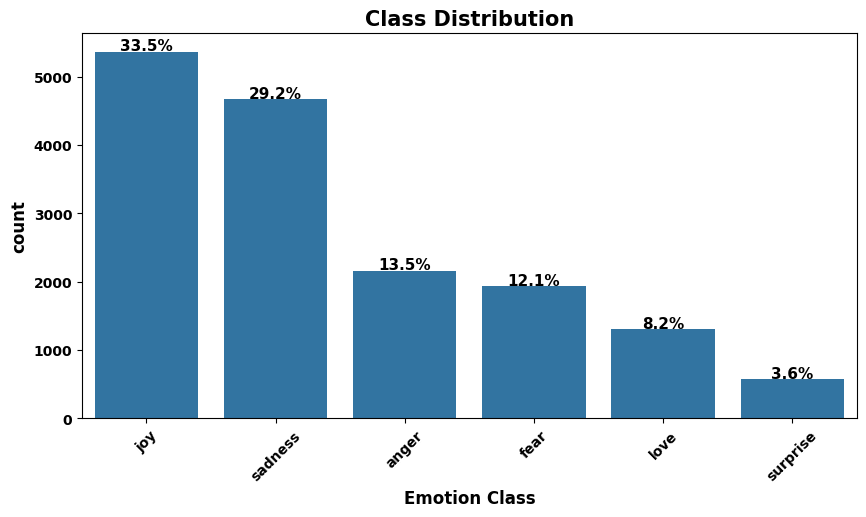

In [ ]:
countplot(10,5,'emotion',15,45,'Emotion Class','Class Distribution')

In [ ]:
# Considering a small set of data as input while debugging
if CFG.debug:
    CFG.epochs = 2
    train = train.sample(frac =.25)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> BERT Tokenizer </h1></span>

The **BERT tokenizer** is a preprocessing tool used to prepare text input for the BERT (Bidirectional Encoder Representations from Transformers) model. It converts raw text into numerical format suitable for model processing by:  

1. **Tokenization**: Breaking the text into smaller subwords or tokens using WordPiece, ensuring efficient handling of rare and unknown words.  
2. **Conversion to Input IDs**: Mapping tokens to unique integers from BERT's vocabulary, forming the `input_ids`. These IDs are fed into the model for training or inference.  
3. **Attention Masks**: Generating `attention_masks` to differentiate between actual tokens (1) and padding tokens (0). This helps the model focus only on relevant parts of the input.  
4. **Special Tokens**: Adding `[CLS]` at the start (for classification tasks) and `[SEP]` at the end (to separate or mark sentence boundaries).  

These processed inputs allow BERT to understand and analyze text effectively, leveraging its bidirectional attention mechanism to capture context and meaning.

In [ ]:
# ====================================================
# Loading Pretrained tokenizer
# ====================================================
OUTPUT_DIR = './'

tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
# ====================================================
# Define max_len
# ====================================================
lengths = []
tk0 = tqdm(train['text'].fillna("").values, total=len(train))
for text in tk0:
    length = len(tokenizer(text, truncation=True, add_special_tokens=False)['input_ids'])
    lengths.append(length)

if max(lengths) + 2 > 512:
    CFG.max_len = 512
else:
    CFG.max_len = max(lengths) + 2 # cls & sep
print(f"max_len: {CFG.max_len}")

  0%|          | 0/4000 [00:00<?, ?it/s]

max_len: 76


# <span><h3 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Tokenization & Collate Function </h3></span>

A dataset with proper format is built to feed the transfomers model. To speed training time, a  collate function  is used. As Neural Network expects the inputs in a same shape, so we do padding in our text data. Normally, in NLP it is done by  `padding the text data upto the max_length`  . But for some short senteces the extra padded token hamper the performance.

As a result, a collate function is used which  padding the text data upto mini-batch max length not the global max_legnth. So, it gives a boost to the training time.

In [ ]:
# the colllate function to increase training speed

def collate(inputs):
    mask_len = int(inputs["attention_mask"].sum(axis=1).max())
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Creating Pytorch Dataset </h1></span>

We are creating a pytorch dataset instance. Basically, in deep learning, we need all data-samples in a batch should be should be the **same legnth**. In NLP, the pad_sequence function, commonly used in frameworks like PyTorch, is essential for handling sequences of variable lengths. It addresses the need for fixed-length input sequences, a requirement for batch processing in neural networks. Sequences of different lengths, prevalent in natural language data, are padded with a special token to ensure uniformity within batches. This step is crucial for maintaining consistent tensor shapes, aligning with the expectations of neural network models, and facilitating efficient batch processing. The pad_sequence function simplifies this padding process, ensuring that shorter sequences are padded appropriately for compatibility with deep learning models.

In [ ]:
# ====================================================
# Dataset Preparation
# ====================================================

def prepare_input(cfg, text):
    inputs = cfg.tokenizer.encode_plus(
        text,
        return_tensors=None,
        add_special_tokens=True,
        max_length=CFG.max_len,
        pad_to_max_length=True,
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long) # making sure everything in pytorch tensor and torch.long (for using CE loss)
    return inputs


class TextDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df[cfg.target_cols].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.long) #making the label repr as the same type
        return inputs, label

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Creating the Model </h1></span>

For Finetuning BERT for text classification, the following steps should be followed:

- **Input Layer** : This layer takes in the input text data, which could be a sequence of words, phrases, or sentences.

- **BERT Encoder** : This layer applies the BERT encoding to the input text data, generating a sequence of vectors that represent the contextualized embeddings of the input text.

- **Pooler** : This layer aggregates the vector representation of the input text, usually by taking the mean or sum pooling, to produce a fixed-length vector that captures the overall meaning of the input text. It is very common to use the representation of the [CLS] token as pooling for classification

- **Classification Head** : This layer consists of a fully connected neural network (FCNN) that takes the pooled vector representation as input and produces a probability distribution over the different classes.

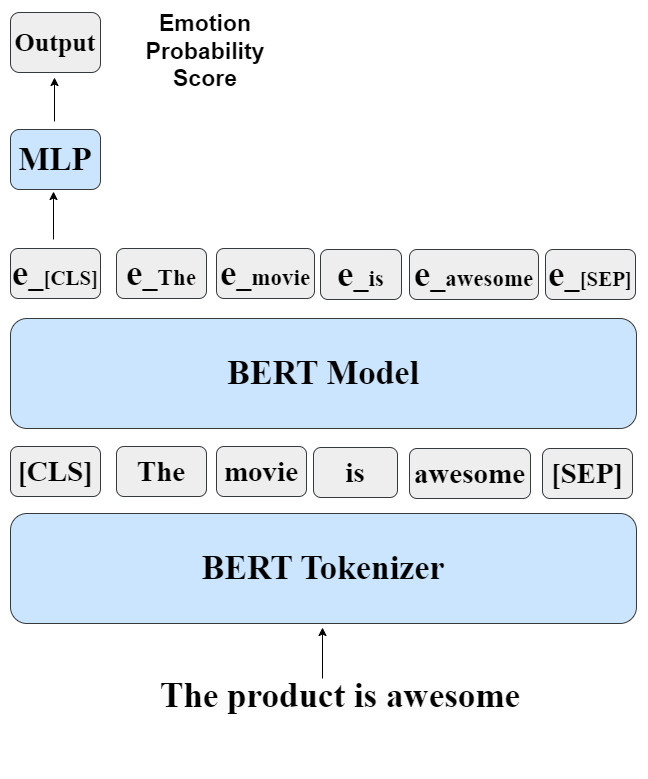

In [ ]:
class BERT_FineTuning(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True, output_attentions=True)
        self.model = AutoModel.from_pretrained(cfg.model, config=self.config) # Loading Pretrained Model
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.num_class) # Classifer Head

    def forward(self, inputs):
        outputs = self.model(**inputs)
        attentions = outputs.attentions
        last_hidden_states = outputs.last_hidden_state # word level representation of last hiddent state

        # pooled sentence representation
        feature = last_hidden_states[:, 0, :] # only  conisdering [CLS] token representations

        logits = self.fc(feature)
        return logits, attentions

In [ ]:
def class_wise_most_attentive_tokens(test_dataset, class_name, num_tokens):
  ls_most_attentive_tokens = []

  # Filterout the test sampels that are belong to that class

  # Iterate through the samples
  # Pass each sample to the model
  # Extract the tokens, predictions and attentions score
  # Find out tokenwise attention score for each token and store them
  # Remember a token can be appear in multiple sentence
  # For all the samples, sort the tokenwise attention score
  return ls_most_attentive_tokens

[]


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Pytorch Code for One Epoch Training </h1></span>

In [ ]:
from sklearn.metrics import f1_score

def get_score(y_trues, y_preds):
    y_predicted = y_preds.argmax(axis=1)  # Convert probabilities to class predictions
    macro_f1 = f1_score(y_trues, y_predicted, average='macro')
    return macro_f1


def train_one_epoch(train_loader, model, optimizer, loss_fn, epoch):
    model.train()
    running_loss = 0
    running_score = 0

    loop = tqdm(enumerate(train_loader),
                         total=len(train_loader), leave=False)

    for i, data in loop:
        inputs, labels = data

        optimizer.zero_grad()

        for k, v in inputs.items():
            inputs[k] = v.to(device)  # formatting the input to feed into the transformer model
        labels = labels.to(device)

        outputs, attentions = model(inputs)
        labels = labels.squeeze()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # compute metrics and store
        score = get_score(labels.to('cpu').detach().numpy(), outputs.to('cpu').detach().numpy())
        running_score += score
        running_loss += loss.item()

        loop.set_description(f"Epoch [{epoch + 1}/{CFG.epochs}]")
        loop.set_postfix(loss=running_loss / (i + 1))

    avg_score = float(score / (i + 1))
    avg_loss = float(loss / (i + 1))

    return avg_score, avg_loss


def eval_one_epoch(valid_loader, model, loss_fn):
    # Validate
    model.eval()
    running_vloss = 0
    running_vscore = 0

    with torch.no_grad():
        for i, vdata in enumerate(valid_loader):
            vinputs, vlabels = vdata
            for k, v in vinputs.items():
              vinputs[k] = v.to(device)  # formatting the input to feed into the transformer model
            vlabels = vlabels.to(device)
            vlabels = vlabels.squeeze()

            voutputs, attentions = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)

            vscore = get_score(vlabels.to('cpu').detach().numpy(), voutputs.to('cpu').detach().numpy())
            running_vscore += vscore
            running_vloss += vloss

    avg_vscore = float(running_vscore / (i + 1))
    avg_vloss = float(running_vloss / (i + 1))

    return avg_vscore, avg_vloss


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Training Loop </h1></span>

In [ ]:
def train_loop():

    model = BERT_FineTuning(CFG) # Initializing the Model
    model = model.to(device)

    # Loss function and optimizer
    loss_fn = nn.CrossEntropyLoss(reduction="mean")
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)

    train_dataset = TextDataset(CFG, train) # training dataset formatting
    valid_dataset = TextDataset(CFG, valid)

    train_loader  = DataLoader(train_dataset,batch_size=CFG.batch_size, shuffle=True)
    valid_loader  = DataLoader(valid_dataset,batch_size=CFG.batch_size, shuffle=False)

    best_score = 0

    for epoch in range(CFG.epochs):

        avg_score, avg_loss = train_one_epoch(train_loader, model, optimizer, loss_fn, epoch)

        avg_vscore, avg_vloss = eval_one_epoch(valid_loader, model, loss_fn)


        # Track best performance and save model's state
        if avg_vscore > best_score:
            best_score = avg_vscore
            model_path = f"best_scored_model.pth"
            torch.save(model.state_dict(), model_path)

        print(f"Epoch {epoch+1}: Training Loss = {avg_loss:.4} Training Score = {avg_score:.4f}", end = " & ")
        print(f"Validation Loss = {avg_vloss:.4f} Validation Score = {avg_vscore:.4f}")

    return best_score

In [ ]:
# ====================================================
# the training
# ====================================================

if __name__ == '__main__':
    best_score = train_loop()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

  0%|          | 0/125 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch 1: Training Loss = 0.006226 Training Score = 0.0055 & Validation Loss = 0.4390 Validation Score = 0.7845


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2: Training Loss = 0.0005619 Training Score = 0.0076 & Validation Loss = 0.2742 Validation Score = 0.8564


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#C01F4D; border-radius: 100px 100px; text-align:center"> Prediction on Test Dataset & Evaluation </h1></span>

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay

def test_model(model, label_names):
    model.eval()
    model.to(device)

    test_dataset = TextDataset(CFG, test)
    test_loader  = DataLoader(test_dataset,batch_size=CFG.batch_size, shuffle=False)

    y_preds = []
    all_labels = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader)):
            inputs, labels = data
            for k, v in inputs.items():
              inputs[k] = v.to(device)  # formatting the input to feed into the transformer model
            labels = labels.to(device)
            labels = labels.squeeze()

            outputs, attentions = model(inputs)
            y_preds.append(outputs.argmax(1))
            all_labels.append(labels)

    y_preds = torch.cat(y_preds)
    y_preds = y_preds.to('cpu').detach().numpy()

    all_labels = torch.cat(all_labels)
    all_labels = all_labels.to('cpu').detach().numpy()

    print(classification_report(all_labels, y_preds, target_names=label_names))
    ConfusionMatrixDisplay.from_predictions(all_labels, y_preds, display_labels=label_names)

    return y_preds

0it [00:00, ?it/s]

              precision    recall  f1-score   support

     sadness       0.91      0.95      0.93       581
         joy       0.92      0.85      0.89       275
        fear       0.72      0.87      0.79       159
        love       0.69      0.65      0.67        66
       anger       0.85      0.86      0.86       224
    surprise       0.95      0.90      0.92       695

    accuracy                           0.89      2000
   macro avg       0.84      0.85      0.84      2000
weighted avg       0.90      0.89      0.89      2000



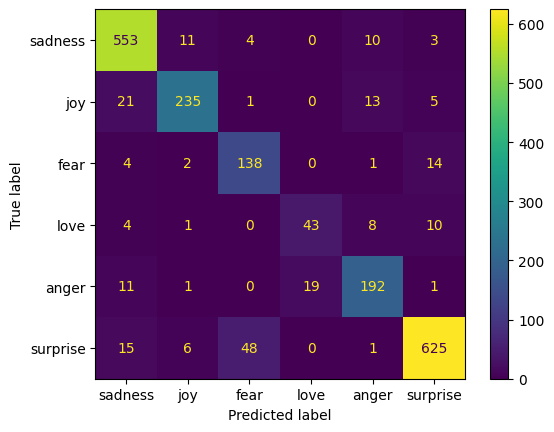

In [ ]:
label_names = train["emotion"].unique()
model = BERT_FineTuning(CFG)
model_path = f"best_scored_model.pth"
state = torch.load(model_path) # loading the saved model

model.load_state_dict(state)
test_set_predictions = test_model(model, label_names)

filter test sample

In [ ]:
print(test_dataset)

NameError: name 'test_dataset' is not defined